In [1]:
import pyroc
import numpy as np
import pandas as pd

## Data

In [2]:
# Load CSV
data = pd.read_csv("tests/data/ovarian_cancer.csv", index_col="idx")

# Imputation (Median)
outcome = data.pop("outcome")
data.albumin = data.albumin.fillna(np.median(data.albumin.dropna()))
data.total_protein = data.total_protein.fillna(np.median(data.total_protein.dropna()))

# Show examples
data.head(5)

,albumin,total_protein,total_score
idx,,,
1,3.0,5.8,0
2,3.2,6.3,5
3,3.9,6.8,7
4,2.8,4.8,4
5,3.2,5.8,7


## Create dictionary with predictor values

In [3]:
from collections import OrderedDict
predictors = OrderedDict({
    "Krebs-Goplerud": data.total_score.values,
    "Albumin": data.albumin.values,
    "Protein": data.total_protein.values
})

## Instantiate ROC object

In [4]:
roc = pyroc.ROC(outcome, predictors)

## Plot ROC curves

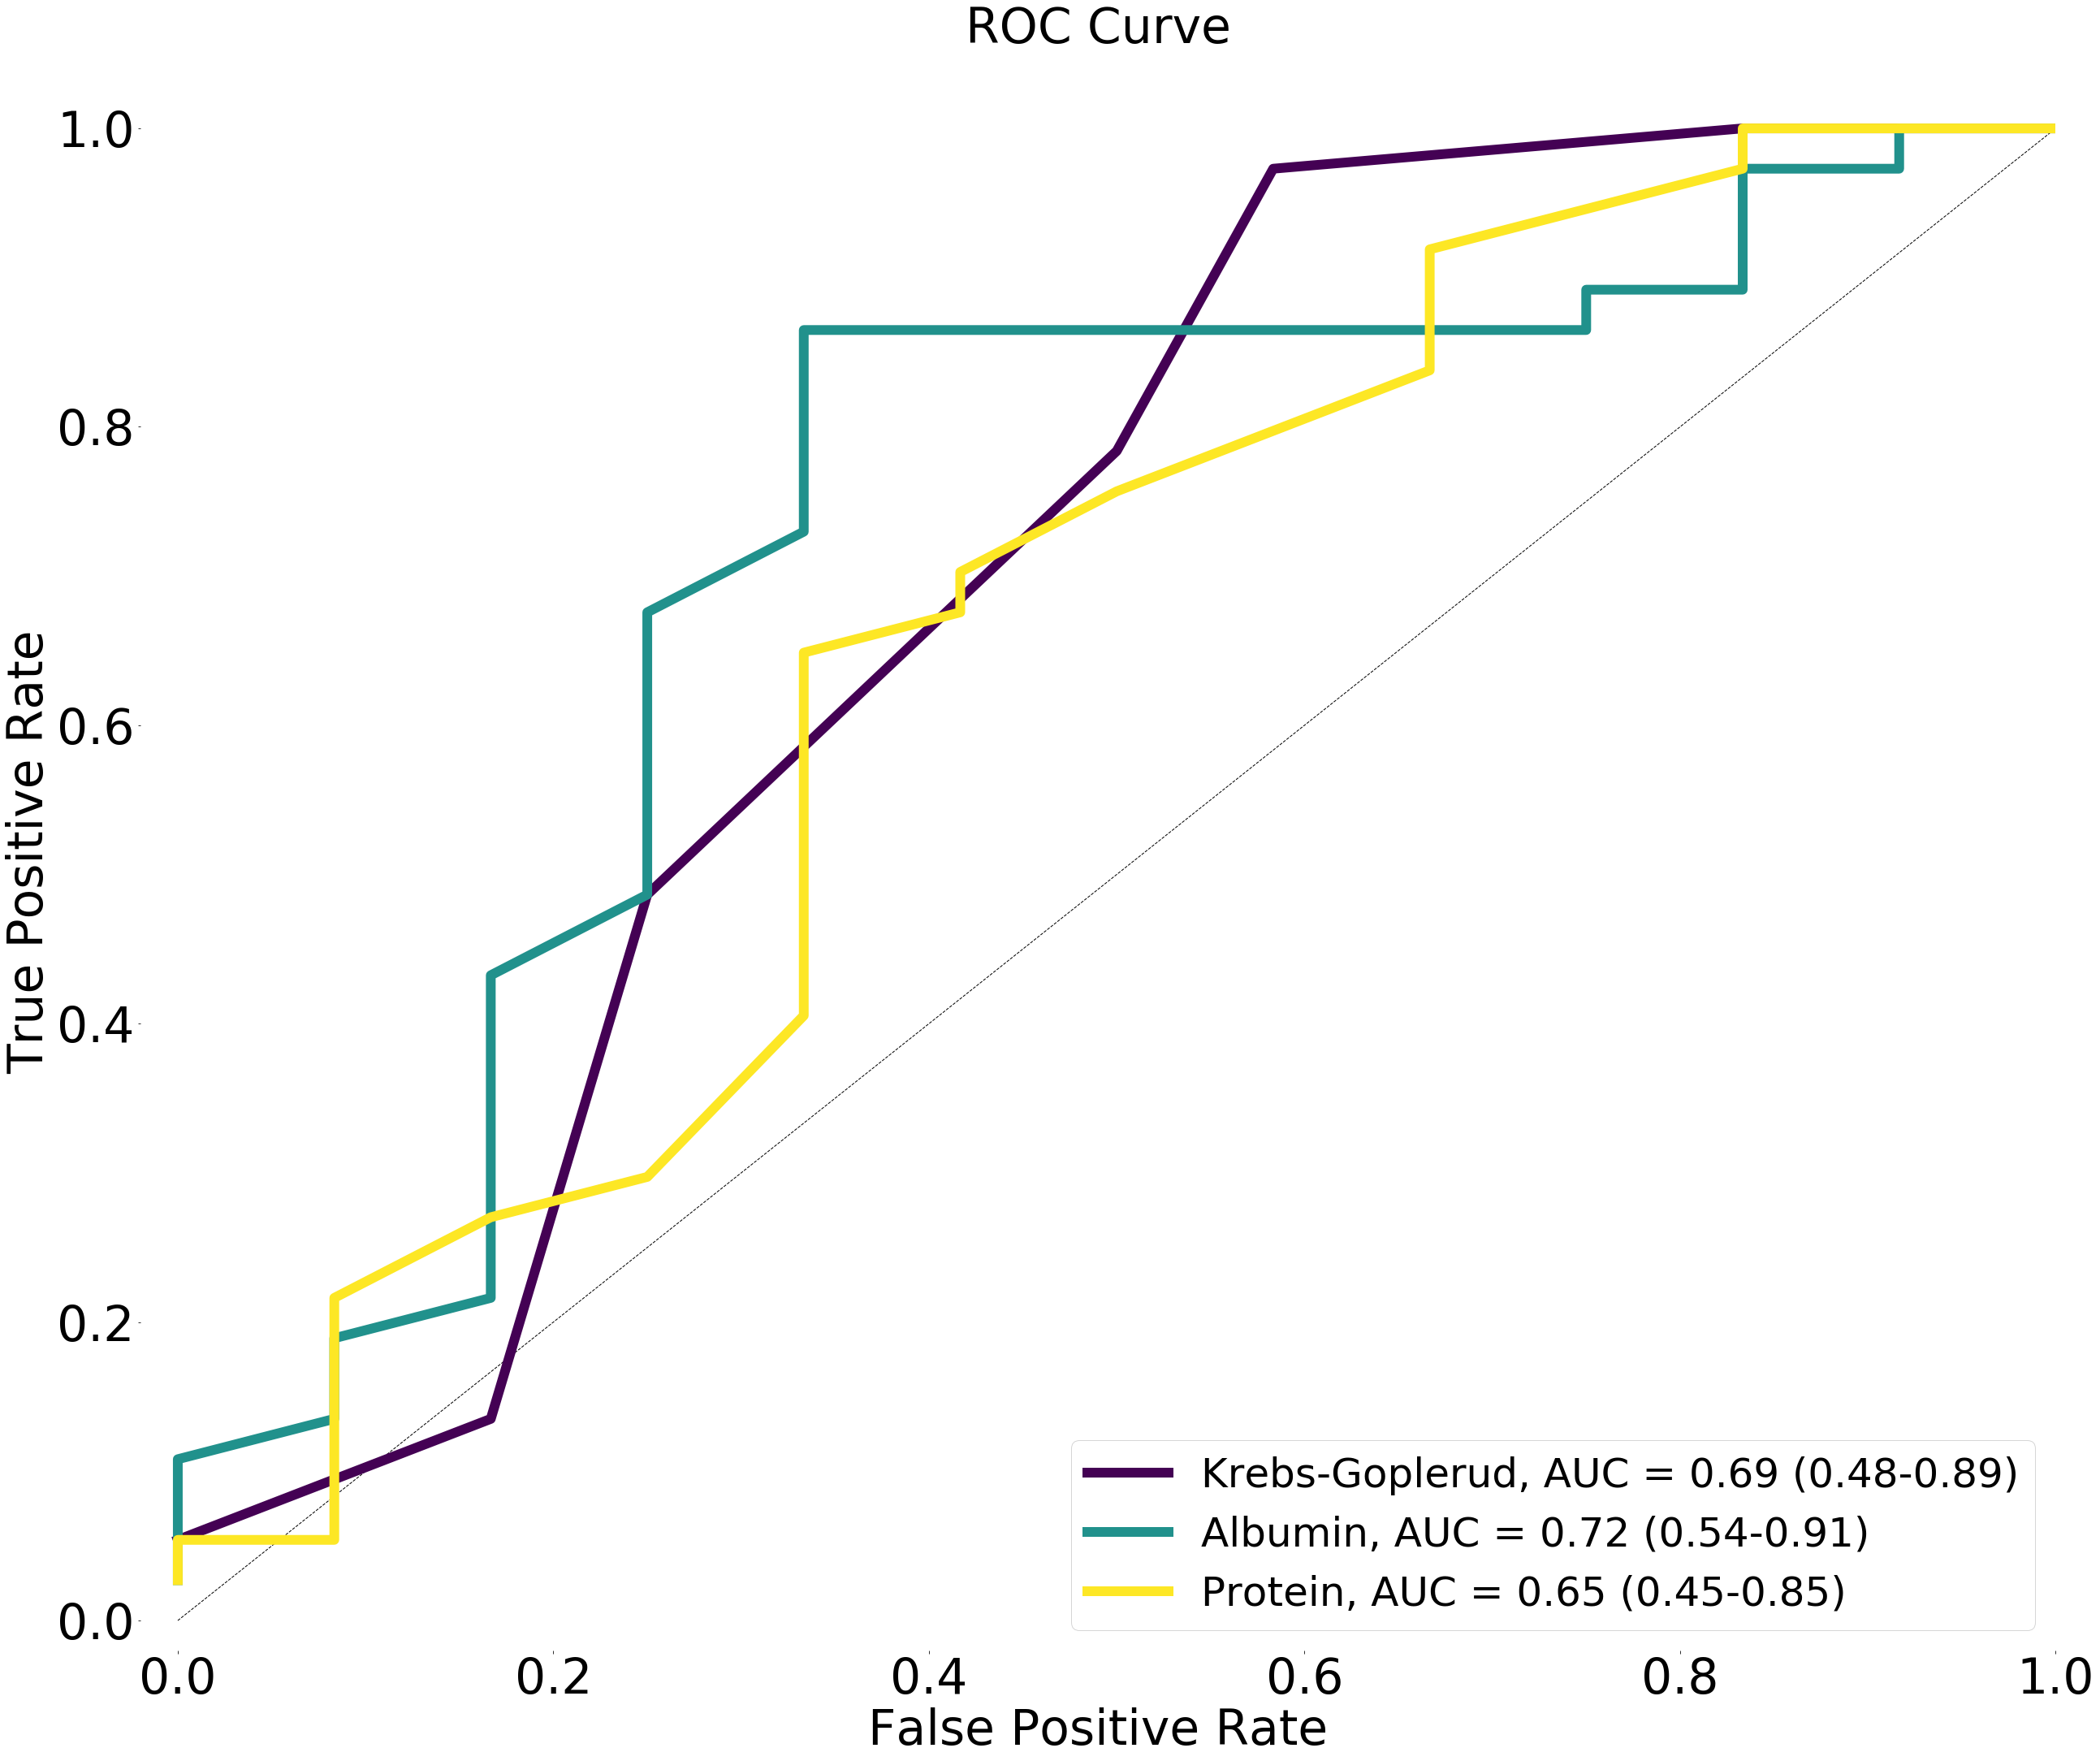

In [5]:
_ = roc.curve()

## Compare Krebs-Goplerud with Albumin and Protein

In [6]:
p, ci = roc.compare(np.array([
    [1, -1,  0],
    [1,  0, -1]
]))
print(p,ci)

0.42291256338063987 [0.05063562 7.37775891]


## AUC and CI values

In [7]:
print(roc.auc)

[[0.68693694 0.72297297 0.6509009 ]]


In [8]:
print(roc.ci()[0], 'lower')
print(roc.ci()[1], 'upper')

[0.48093018 0.53737381 0.44915782] lower
[0.8929437  0.90857213 0.85264398] upper
